# Hyperparameter Tuning
### 1.GridSearchCV
### 2.RandomSearch 
### 3.RandomizedSearchCV
### 4.Bayesian Optimization

In [1]:
import os
import pandas as pd
import numpy as np
#os.cpu_count()

In [2]:
df = pd.read_csv('credit-card-full.csv')

In [3]:
df.head()
X = df.loc[:,df.columns != 'default payment next month']
y = df.loc[:,df.columns == 'default payment next month']

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Create the function
def gbm_grid_search(learn_rate, max_depth):

    # Create the model
    model = GradientBoostingClassifier(learning_rate=learn_rate, max_depth=max_depth)
    
    # Use the model to make predictions
    predictions = model.fit(X_train, y_train).predict(X_test)
    
    # Return the hyperparameters and score
    return([learn_rate, max_depth, accuracy_score(y_test, predictions)])

## GridSearchCV

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# Create a Random Forest Classifier with specified criterion
rf_class = RandomForestClassifier(criterion='entropy')

# Create the parameter grid
param_grid = {'max_depth': [2, 4, 8, 15], 'max_features': ['auto','sqrt']} 

# Create a GridSearchCV object
grid_rf_class = GridSearchCV(
    estimator=rf_class,
    param_grid=param_grid,
    scoring='roc_auc',
    n_jobs=4,
    cv=5,
    refit=True, return_train_score=True)

#print(grid_rf_class)
grid_rf_class.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
  

In [6]:
# Read the cv_results property into a dataframe & print it out
cv_results_df = pd.DataFrame(grid_rf_class.cv_results_)
print("CV Results")
print(cv_results_df)

# Extract and print the column with a dictionary of hyperparameters used
column = cv_results_df.loc[:, ['params']]
print("Parameter Columns")
print(column)

# Extract and print the row that had the best mean test score
best_row = cv_results_df[cv_results_df['rank_test_score'] == 1 ]
print("Show me the best row")
print(best_row)

CV Results
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       2.024116      0.015428         0.092605        0.039825   
1       1.988714      0.041910         0.060404        0.002417   
2       3.464798      0.060886         0.070204        0.001939   
3       3.690011      0.141475         0.073404        0.004883   
4       7.513630      0.315659         0.120207        0.028296   
5       8.154266      0.596821         0.107806        0.005076   
6      14.179611      0.604911         0.204012        0.066841   
7      13.117350      1.757604         0.164210        0.064785   

  param_max_depth param_max_features  \
0               2               auto   
1               2               sqrt   
2               4               auto   
3               4               sqrt   
4               8               auto   
5               8               sqrt   
6              15               auto   
7              15               sqrt   

                        

**Analyzing the best results**

In [7]:
# Print out the ROC_AUC score from the best-performing square
best_score = grid_rf_class.best_score_
print("The best score is ", str(best_score))
print("-----------------------------")

# Create a variable from the row related to the best-performing square
cv_results_df = pd.DataFrame(grid_rf_class.cv_results_)
best_row = cv_results_df.loc[[grid_rf_class.best_index_]]
print('Details of the best row are as follow')
print(best_row)

# Get the n_estimators parameter from the best-performing square and print
#best_n_estimators = grid_rf_class.best_params_["n_estimators"]
#print(best_n_estimators)

The best score is  0.7821089323390299
-----------------------------
Details of the best row are as follow
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5       8.154266      0.596821         0.107806        0.005076   

  param_max_depth param_max_features  \
5               8               sqrt   

                                     params  split0_test_score  \
5  {'max_depth': 8, 'max_features': 'sqrt'}           0.778359   

   split1_test_score  split2_test_score  ...  mean_test_score  std_test_score  \
5             0.7803           0.778726  ...         0.782109        0.005362   

   rank_test_score  split0_train_score  split1_train_score  \
5                1            0.832232            0.831768   

   split2_train_score  split3_train_score  split4_train_score  \
5            0.833427            0.830437            0.833287   

   mean_train_score  std_train_score  
5           0.83223         0.001093  

[1 rows x 22 columns]


**Using the best results**

In [8]:
from sklearn.metrics import confusion_matrix, roc_auc_score
# See what type of object the best_estimator_ property is
print(type(grid_rf_class.best_estimator_))

# Create an array of predictions directly using the best_estimator_ property
predictions = grid_rf_class.best_estimator_.predict(X_test)

# Take a look to confirm it worked, this should be an array of 1's and 0's
print(predictions[0:5])

# Now create a confusion matrix 
print("Confusion Matrix \n", confusion_matrix(y_test, predictions))

# Get the ROC-AUC score
predictions_proba = grid_rf_class.best_estimator_.predict_proba(X_test)[:,1]
print("ROC-AUC Score \n", roc_auc_score(y_test, predictions_proba))

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
[0 0 0 0 0]
Confusion Matrix 
 [[6696  338]
 [1302  664]]
ROC-AUC Score 
 0.7746597618716359


## Random Search

In [9]:
from itertools import product
# Create a list of values for the learning_rate hyperparameter
learn_rate_list = list(np.linspace(0.01,1.5,200))

# Create a list of values for the min_samples_leaf hyperparameter
min_samples_list = list(range(10,41))

# Combination list
combinations_list = [list(x) for x in product(learn_rate_list, min_samples_list)]

# Sample hyperparameter combinations for a random search.randomly getting 250 samples
random_combinations_index = np.random.choice(range(0, len(combinations_list)), 250, replace=False)
combinations_random_chosen = [combinations_list[x] for x in random_combinations_index]

# Print the result
print(combinations_random_chosen)

[[0.33195979899497485, 21], [0.5416080402010051, 14], [0.12979899497487438, 15], [0.30201005025125627, 12], [1.4101507537688442, 32], [0.27954773869346733, 24], [0.5266331658291458, 36], [0.024974874371859294, 19], [0.796180904522613, 17], [1.455075376884422, 19], [1.1406030150753768, 35], [0.10733668341708542, 36], [0.34693467336683415, 24], [0.09984924623115578, 13], [1.0208040201005024, 38], [0.34693467336683415, 36], [0.08487437185929647, 30], [1.372713567839196, 16], [1.4026633165829145, 13], [0.668894472361809, 31], [0.7737185929648241, 29], [1.3203015075376885, 15], [0.6164824120603015, 27], [0.21964824120603016, 30], [0.039949748743718594, 14], [1.3128140703517588, 13], [0.12231155778894472, 28], [1.372713567839196, 39], [1.07321608040201, 39], [0.34693467336683415, 38], [0.31698492462311556, 24], [1.07321608040201, 37], [0.5565829145728644, 21], [0.9908542713567839, 31], [0.3768844221105528, 21], [0.17472361809045225, 26], [0.4292964824120603, 38], [0.5715577889447236, 31], [1

In [10]:
print(len(min_samples_list))
print(len(learn_rate_list))
print(len(combinations_list))
print(len(random_combinations_index))

31
200
6200
250


#### Randomly Search with Random Forest

In [11]:
import random
# Create lists for criterion and max_features
criterion_list = ['gini','entropy']
max_feature_list = ['auto','sqrt','log2',None]

# Create a list of values for the max_depth hyperparameter
max_depth_list = list(range(3,56))

# Combination list
combinations_list = [list(x) for x in product(criterion_list, max_feature_list, max_depth_list)]
print("Length of combination lists :" + str(len(combinations_list)))
# Sample hyperparameter combinations for a random search
combinations_random_chosen = random.sample(combinations_list, 150)

# Print the result
#print(combinations_random_chosen)

Length of combination lists :424


**Demonstrating how randomly selected combo will cover most areas**

In [12]:
import matplotlib.pyplot as plt
def sample_and_visualize_hyperparameters(n_samples):
    #x_lims = [0.01, 1.5]
    #y_lims = [0.01, 1.5]
    # If asking for all combinations, just return the entire list.\n  
    if n_samples == len(combinations_list):    
        combinations_random_chosen = combinations_list  
    else:    
        combinations_random_chosen = []   
        random_combinations_index = np.random.choice(range(0, len(combinations_list)), n_samples, replace=False)    
        combinations_random_chosen = [combinations_list[x] for x in random_combinations_index]  
    # Pull out the X and Y to plot\n  
    rand_y, rand_x = [x[0] for x in combinations_random_chosen], [x[1] for x in combinations_random_chosen]  
    # Plot   
    plt.clf() 
    plt.scatter(rand_y, rand_x, c=['blue']*len(combinations_random_chosen))  
    plt.gca().set(xlabel='learn_rate', ylabel='min_samples_leaf', title='Random Search Hyperparameters') 
    #plt.gca().set_xlim(x_lims) 
    #plt.gca().set_ylim(y_lims)  
    plt.show()

**Visualizing the random search**

2000


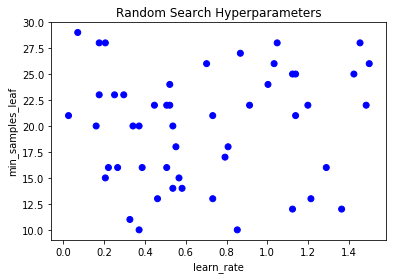

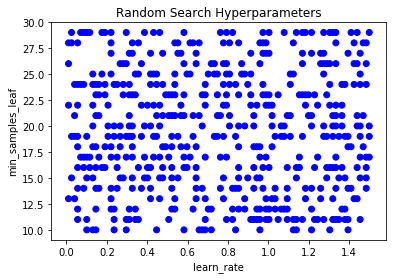

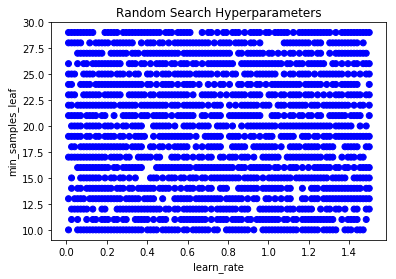

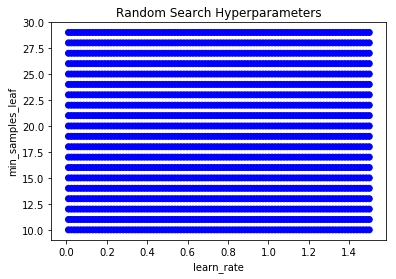

In [13]:
# Create a list of values for the learning_rate hyperparameter
learn_rate_list = list(np.linspace(0.01,1.5,100))

# Create a list of values for the min_samples_leaf hyperparameter
min_samples_list = list(range(10,30))

# Combination list
combinations_list = [list(x) for x in product(learn_rate_list, min_samples_list)]
#######################################################

# Confirm how many hyperparameter combinations & print
number_combs = len(combinations_list)
print(number_combs)

# Sample and visualise specified combinations
for x in [50, 500, 1500]:
    sample_and_visualize_hyperparameters(x)


# Sample all the hyperparameter combinations & visualise
sample_and_visualize_hyperparameters(number_combs)

## RandomizedSearchCV

In [14]:
from sklearn.model_selection import RandomizedSearchCV
# Create the parameter grid
param_grid = {'learning_rate': np.linspace(0.1,2,150), 'min_samples_leaf': list(range(20,65))} 

# Create a random search object
random_GBM_class = RandomizedSearchCV(
    estimator = GradientBoostingClassifier(),
    param_distributions = param_grid,
    n_iter = 10, #Number of parameter settings that are sampled.
    scoring='accuracy', n_jobs=4, cv = 5, refit=True, return_train_score = True)

# Fit to the training data
random_GBM_class.fit(X_train, y_train)

# Print the values used for both hyperparameters
print(random_GBM_class.cv_results_['param_learning_rate'])
print(random_GBM_class.cv_results_['param_min_samples_leaf'])

[1.1073825503355705 1.3114093959731543 1.3114093959731543
 0.125503355704698 0.9161073825503355 1.2731543624161075
 0.2657718120805369 0.6483221476510067 1.1583892617449665
 1.6429530201342282]
[61 36 27 24 57 29 51 25 39 43]


**RandomForestClassifier**

In [15]:
# Create the parameter grid
param_grid = {'max_depth': list(range(5,26)), 'max_features': ['auto' , 'sqrt']} 

# Create a random search object
random_rf_class = RandomizedSearchCV(
    estimator = RandomForestClassifier(n_estimators=80),
    param_distributions = param_grid, n_iter = 5,
    scoring='roc_auc', n_jobs=4, cv = 3, refit=True, return_train_score = True )

# Fit to the training data
random_rf_class.fit(X_train, y_train)

# Print the values used for both hyperparameters
print(random_rf_class.cv_results_['param_max_depth'])
print(random_rf_class.cv_results_['param_max_features'])

[11 17 22 8 21]
['sqrt' 'sqrt' 'sqrt' 'sqrt' 'sqrt']


#### Visualizing side by side

In [16]:
def visualize_search(grid_combinations_chosen, random_combinations_chosen): 
    #x_lims = [0.01, 3.0]
    #y_lims = [0.01, 3.0]
    grid_y, grid_x = [x[0] for x in grid_combinations_chosen], [x[1] for x in grid_combinations_chosen] 
    rand_y, rand_x = [x[0] for x in random_combinations_chosen], [x[1] for x in random_combinations_chosen] 
    # Plot all together  
    plt.scatter(grid_y + rand_y, grid_x + rand_x, c=['red']*300 + ['blue']*300)
    plt.gca().set(xlabel='learn_rate', ylabel='min_samples_leaf', title='Grid and Random Search Hyperparameters')  
    #plt.gca().set_xlim(x_lims)  
    #plt.gca().set_ylim(y_lims)  
    plt.show()

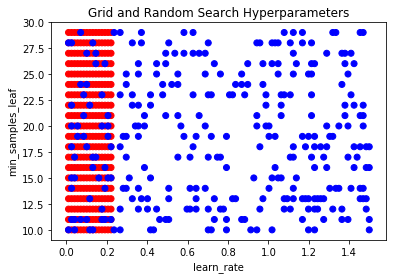

In [17]:
# Sample grid coordinates
grid_combinations_chosen = combinations_list[0:300]

# Create a list of sample indexes
sample_indexes = list(range(0,len(combinations_list)))

# Randomly sample 300 indexes
random_indexes = np.random.choice(sample_indexes, 300, replace=False)

# Use indexes to create random sample
random_combinations_chosen = [combinations_list[index] for index in random_indexes]

# Call the function to produce the visualization
visualize_search(grid_combinations_chosen, random_combinations_chosen)

## Bayes Optimization Hyperparameter Tuning
- Pick a hyperparameter combination
- Build a model
- Get new evidence (the score of the model)
- Update our beliefs and chose better hyperparameters next round


**Bayesian optimization**, also called Sequential Model-Based Optimization (SMBO), implements this idea by building a probability model of the objective function that maps input values to a probability of a loss: p (loss | input values). The probability model, also called the surrogate or response surface, is easier to optimize than the actual objective function. Bayesian methods select the next values to evaluate by applying a criteria (usually Expected Improvement) to the surrogate. The concept is to limit evals of the objective function by spending more time choosing the next values to try.



*Optimization Example in Hyperopt*<br>
Formulating an optimization problem in Hyperopt requires four parts:
1. **Objective Function**: takes in an input and returns a loss to minimize
2. **Domain space**: the range of input values to evaluate
3. **Optimization Algorithm**: the method used to construct the surrogate function and choose the next values to evaluate
4. **Results**: score, value pairs that the algorithm uses to build the model


##### Key Takes for Bayesian Optimization
1. Bayesian Optimization is an efficient method for finding the minimum of a function that works by constructing a probabilistic (surrogate) model of the objective function
2. The surrogate is informed by past search results and, by choosing the next values from this model, the search is concentrated on promising values
3. The overall outcome of these method is reduced search time and better values
4. These powerful techniques can be implemented easily in Python libraries like Hyperopt
5. The Bayesian optimization framework can be extended to complex problems including hyperparameter tuning of machine learning models

These are the probabilities we know:

7% (0.07) of people are likely to close their account next month<br>
15% (0.15) of people with accounts are unhappy with your product (you don't know who though!)<br>
35% (0.35) of people who are likely to close their account are unhappy with your product<br>



In [18]:
# Basic Rule in Python
# Assign probabilities to variables 
p_unhappy = 0.15
p_unhappy_close = 0.35

# Probabiliy someone will close
p_close = 0.07

# Probability unhappy person will close
p_close_unhappy = (p_unhappy_close * p_close) / p_unhappy
print(p_close_unhappy)

0.16333333333333336


In [25]:
from hyperopt import fmin, tpe, hp, Trials, rand
from sklearn.model_selection import cross_val_score
from hyperopt import STATUS_OK
from timeit import default_timer as timer


# Set up space dictionary with specified hyperparameters
space = {'max_depth': hp.quniform('max_depth', 2, 10, 2),'learning_rate': hp.uniform('learning_rate', 0.001, 0.9)}

# Set up objective function
def objective(params):
    params = {'max_depth': int(params['max_depth']),'learning_rate': params['learning_rate']}
    start = timer()
    gbm_clf = GradientBoostingClassifier(n_estimators=100, **params) 
    best_score = cross_val_score(gbm_clf, X_train, y_train, scoring='accuracy', cv=2, n_jobs=4).mean()
    end=timer()
    time_elapsed = end - start
    loss = 1 - best_score
    return {'loss': loss, 'status': STATUS_OK, 'params': params, 'time': time_elapsed}

# create 2 trials objects
tpe_trials = Trials()
rand_trials = Trials()

#There are two choices for a hyperparameter optimization algorithm in Hyperopt: random and Tree Parzen Estimator.
# Run the algorithm
## TPE
tpe_best = fmin(fn=objective,space=space, max_evals=20, rstate=np.random.RandomState(42), algo=tpe.suggest, trials=tpe_trials)
print(tpe_best)

#RAND
rand_best = fmin(fn=objective,space=space, max_evals=20, rstate=np.random.RandomState(42), algo=rand.suggest, trials=rand_trials)
print(rand_best)

100%|██████████| 20/20 [05:11<00:00, 15.56s/trial, best loss: 0.1844285714285714]
{'learning_rate': 0.11310589268581149, 'max_depth': 6.0}
100%|██████████| 20/20 [05:50<00:00, 17.50s/trial, best loss: 0.18547619047619046]
{'learning_rate': 0.0128515490384306, 'max_depth': 6.0}


In [28]:
tpe_results = tpe_trials.results

# Results into a dataframe
tpe_results_df = pd.DataFrame({'time': [x['time'] for x in tpe_results], 
                           'loss': [x['loss'] for x in tpe_results],
                           'x': [x['params'] for x in tpe_results],
                            'iteration': list(range(len(tpe_results)))})

# Sort with lowest loss on top
tpe_results_df = tpe_results_df.sort_values('loss', ascending = True)
tpe_results_df.head()

,time,loss,x,iteration
16,14.473758,0.184429,"{'max_depth': 6, 'learning_rate': 0.1131058926...",16
13,12.931596,0.185429,"{'max_depth': 6, 'learning_rate': 0.0128515490...",13
4,15.968169,0.190762,"{'max_depth': 8, 'learning_rate': 0.1555125336...",4
10,4.664883,0.192190,"{'max_depth': 2, 'learning_rate': 0.7362291876...",10
12,21.479746,0.194429,"{'max_depth': 10, 'learning_rate': 0.277225089...",12


In [30]:
rand_results = rand_trials.results

# Results into a dataframe
rand_results_df = pd.DataFrame({'time': [x['time'] for x in rand_results], 
                           'loss': [x['loss'] for x in rand_results],
                           'x': [x['params'] for x in rand_results],
                            'iteration': list(range(len(rand_results)))})

# Sort with lowest loss on top
rand_results_df = rand_results_df.sort_values('loss', ascending = True)
rand_results_df.head()

,time,loss,x,iteration
13,20.383151,0.185476,"{'max_depth': 6, 'learning_rate': 0.0128515490...",13
16,14.974467,0.186381,"{'max_depth': 6, 'learning_rate': 0.1131058926...",16
10,4.804515,0.192429,"{'max_depth': 2, 'learning_rate': 0.7362291876...",10
4,16.846039,0.192714,"{'max_depth': 8, 'learning_rate': 0.1555125336...",4
12,36.130110,0.195143,"{'max_depth': 10, 'learning_rate': 0.277225089...",12


#### Genetics & Machine Learning
1. There are many creatures exsiting ('offspring')
2. The strongest creatures survive and pair off
3. There is some 'crossover' as they form offspring
4. There are random mutations to some of the offspring. These mutations sometimes help give some offspring an advantage
5. Go back to 1

**Apply the same idea to hyperparameter tuning**
1. We can create some models (that have hyperparameter settings)
2. We can pick the best (by our scoring function), these are the ones that 'survive'
3. We can create new models that are similar to the best ones
4. We add in some randomness so we don't reach a local optimum
5. Repeat until we are happy!

This is an informed search because it allows us to learn from previous iterations, just like bayesian hyperparameter tuning, with an additional advantage of some randomness

**TPOT**
- generations: iterations to run training for
- population_size: the number of models to keep after each iteration
- offspring_size: number of models to produce in each iteration
- mutation_rate: the proportion of pipelines to apply randomness to
- crossover_rate: the proportion of pipelines to breed each iteration
- scoring - the function to determine the best models
- cv: cross-validation strategy to use

[TPOT DOC](https://github.com/discdiver/tpot)

In [32]:
from tpot import TPOTClassifier
# Assign the values outlined to the inputs
number_generations = 3
population_size = 4
offspring_size = 3
scoring_function = 'accuracy'

# Create the tpot classifier
tpot_clf = TPOTClassifier(generations=number_generations, population_size=population_size,
                          offspring_size=offspring_size, scoring=scoring_function,
                          verbosity=2, random_state=2, cv=5)

# Fit the classifier to the training data
tpot_clf.fit(X_train, y_train)

# Score on the test set
print(tpot_clf.score(X_test, y_test))

# try a different random state, it 1,2,3,4,5,55,76,43 whatever

Generation 1 - Current best internal CV score: 0.8174285714285713
Generation 2 - Current best internal CV score: 0.8174285714285713
Generation 3 - Current best internal CV score: 0.8174285714285713

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=gini, max_features=0.6000000000000001, min_samples_leaf=3, min_samples_split=12, n_estimators=100)
0.8184444444444444


In [31]:
# Create the tpot classifier
tpot_clf = TPOTClassifier(generations=number_generations, population_size=population_size,
                          offspring_size=offspring_size, scoring=scoring_function,
                          verbosity=2, random_state=22, cv=5)

# Fit the classifier to the training data
tpot_clf.fit(X_train, y_train)

# Score on the test set
print(tpot_clf.score(X_test, y_test))

Generation 1 - Current best internal CV score: 0.82
Generation 2 - Current best internal CV score: 0.82
Generation 3 - Current best internal CV score: 0.82

Best pipeline: DecisionTreeClassifier(input_matrix, criterion=gini, max_depth=3, min_samples_leaf=17, min_samples_split=11)
0.8211111111111111


In [33]:
# Create the tpot classifier
tpot_clf = TPOTClassifier(generations=number_generations, population_size=population_size,
                          offspring_size=offspring_size, scoring=scoring_function,
                          verbosity=2, random_state=62, cv=5)

# Fit the classifier to the training data
tpot_clf.fit(X_train, y_train)

# Score on the test set
print(tpot_clf.score(X_test, y_test))

Generation 1 - Current best internal CV score: 0.8196666666666668
Generation 2 - Current best internal CV score: 0.8205714285714285
Generation 3 - Current best internal CV score: 0.8205714285714285

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.1, max_depth=3, max_features=0.8, min_samples_leaf=3, min_samples_split=17, n_estimators=100, subsample=0.7000000000000001)
0.8211111111111111


#### Key Takeaway
**Hyperparameters vs Parameters**
Hyperparameters are components of the model that you set. They are not learned during the modeling process. Parameters are not set by you. The algorithm will discover these for you

**Which hyperparameters & values**
- Some hyperparameters are better to start with than others
- There are silly values you can set for hyperparameters
- You need to beware of conflicting hyperparameters
- Best practice is specific to algorithms and their hyperparameters

**Grid Search**
- Construct a matrix or grid of hyperparameter combinations and values
- Build models for all the different hyperparameter combinations
- then pick the winner
A computationally expensive option but is guaranteed to find the best in your grid.

**Random Search**
- very similar to grid search
- maiin difference is selecting random combinations
This method is faster at getting a reasonable model but will not get the best in your grid

**Informed search**
> in informed search, each iteration learns from the last, whereas in Grid and Random, modeling is all done at once and then the best is picked

- 'Course to fine' (Iterative rando then grid search)
- Bayesian hyperparameter tuning, updating beliefs using evidence on model performance
- Genetic algorithms, evolving your models over generations